# M02. Predict PAs
- Predict outs vs. safe
- Predict out type
- Predict safe type

In [3]:
%run "U1. Imports.ipynb"
%run "U2. Utilities.ipynb"
%run "U3. Classes.ipynb"

baseball_path = r'C:\Users\james\Documents\MLB\Database'

db_path = r'C:\Users\james\Documents\MLB\Database\MLBDB.db'
engine = create_engine(f'sqlite:///{db_path}')

In [4]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import log_loss, classification_report, f1_score, make_scorer
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.inspection import permutation_importance
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.cluster import KMeans
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from tensorflow import keras
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC

import joblib
import matplotlib.pyplot as plt

In [5]:
%run "A02. MLB API.ipynb"
%run "A03. Steamer.ipynb"

In [6]:
# Set option to display numbers without scientific notation
pd.set_option('display.float_format', '{:.6f}'.format)

### Dataset

In [7]:
complete_dataset = create_pa_inputs(park_factors, team_map, 2015, 2023, short=50, long=300)

##### Inputs

In [8]:
# Standardize
complete_dataset[batter_inputs] = batter_stats_scaler.transform(complete_dataset[batter_inputs])
complete_dataset[pitcher_inputs] = pitcher_stats_scaler.transform(complete_dataset[pitcher_inputs])

### Steamer

In [9]:
# Read in Steamer hitters 
steamer_hitters_df = pd.read_csv(os.path.join(baseball_path, "A03. Steamer", "steamer_hitters_weekly_log.csv"), encoding='iso-8859-1')
# Clean
steamer_hitters_df2 = clean_steamer_hitters(steamer_hitters_df)
steamer_hitters_df2.dropna(subset=batter_stats_fg, inplace=True)

In [10]:
# Read in Steamer hitters 
steamer_pitchers_df = pd.read_csv(os.path.join(baseball_path, "A03. Steamer", "steamer_pitchers_weekly_log.csv"), encoding='iso-8859-1')
# Clean
steamer_pitchers_df2 = clean_steamer_pitchers(steamer_pitchers_df)
steamer_pitchers_df2.dropna(subset=pitcher_stats_fg2, inplace=True)

In [11]:
# Standardize
steamer_hitters_df2[batter_stats_fg] = batter_stats_fg_scaler.transform(steamer_hitters_df2[batter_stats_fg])
steamer_pitchers_df2[pitcher_stats_fg] = pitcher_stats_fg_scaler.transform(steamer_pitchers_df2[pitcher_stats_fg])

### Merge

In [12]:
# Find the dates of Steamer projections
# We'll take the most recent and merge in that projection for each player
batter_steamer_dates = list(steamer_hitters_df2['date'].unique())
pitcher_steamer_dates = list(steamer_pitchers_df2['date'].unique())

# Define a function to find the largest number in "steamer_dates" less than or equal to a given "date"
def find_steamer_date(date, steamer_dates):
    max_steamer_date = max(filter(lambda d: d <= date, steamer_dates), default=None)
    return max_steamer_date

# Apply the function to create the "steamer_date" column in your DataFrame
complete_dataset["batter_date"] = complete_dataset["date"].apply(lambda x: find_steamer_date(x, batter_steamer_dates))
complete_dataset["pitcher_date"] = complete_dataset["date"].apply(lambda x: find_steamer_date(x, pitcher_steamer_dates))

In [13]:
# Steamer stats we want to keep
batter_stats_fg_plus = ['mlbamid', 'steamerid', 'date'] + batter_stats_fg 
pitcher_stats_fg_plus = ['mlbamid', 'steamerid', 'date'] + pitcher_stats_fg 

# Merge
complete_merged_df = pd.merge(complete_dataset, steamer_hitters_df2[batter_stats_fg_plus], left_on=['batter', 'batter_date'], right_on=['mlbamid', 'date'], how='inner')
complete_merged_df = pd.merge(complete_merged_df, steamer_pitchers_df2[pitcher_stats_fg_plus], left_on=['pitcher', 'pitcher_date'], right_on=['mlbamid', 'date'], how='inner')

### Impute

##### Option 1: Steamer

In [14]:
# Add hands to use in imputation
batter_stats_fg_imp = batter_stats_fg + ['b_L', 'p_L']
pitcher_stats_fg_imp = pitcher_stats_fg + ['b_L', 'p_L']

### Batters
# Use Steamer stats to predict API/Statcast stats for those with limited samples
batter_predictions = batter_imputations_model.predict(complete_merged_df.loc[complete_merged_df['pa_b'] < 40, batter_stats_fg_imp])

# Impute inputs with limited sample size with predicted values
complete_merged_df.loc[complete_merged_df['pa_b'] < 40, batter_inputs] = batter_predictions

### Pitchers
# Use Steamer stats to predict API/Statcast stats for those with limited samples
pitcher_predictions = pitcher_imputations_model.predict(complete_merged_df.loc[complete_merged_df['pa_p'] < 40, pitcher_stats_fg_imp])

# Impute inputs with limited sample size with predicted values
complete_merged_df.loc[complete_merged_df['pa_p'] < 40, pitcher_inputs] = pitcher_predictions

##### Option 2: 0s

In [15]:
# # Testing instead of imputing, just weighting with 0s
# complete_merged_df[batter_inputs].fillna(0, inplace=True)
# complete_merged_df[pitcher_inputs].fillna(0, inplace=True)

# # Calculate the weighted average for each column in pitcher_stats
# # Could be simplified, but I wanted to show the steps
# # Weighted average of provided value and 0. PAs and 50-PAs are weights. 
# for col in batter_inputs:
#     complete_merged_df[col] = (complete_merged_df[col] * complete_merged_df['pa_b'] + 0 * (50-complete_merged_df['pa_b']))/50

# # Calculate the weighted average for each column in pitcher_stats
# for col in pitcher_inputs:
#     complete_merged_df[col] = (complete_merged_df[col] * complete_merged_df['pa_p'] + 0 * (50-complete_merged_df['pa_p']))/50

### Train Models

##### Dataset

In [16]:
# Filter out events that didn't end with reaching base or an out
complete_merged_df = complete_merged_df.query('eventsModel != "Cut"').reset_index(drop=True)
# Drop early observations (these will generally treat veterans as rookies and could bias results
complete_merged_df = complete_merged_df.drop(index=complete_merged_df.index[:20000])
complete_merged_df.reset_index(inplace=True, drop=True)
# Create year variable
complete_merged_df['year'] = complete_merged_df['date'].astype('str').str[:4]
# Create is_out binary variable
out_list = ['so', 'fo', 'go', 'lo', 'po']
complete_merged_df['is_out'] = complete_merged_df['eventsModel'].str.contains('|'.join(out_list)).astype(int)

In [17]:
# Keep relevant variables
### TESTING
# keep_list = pa_inputs + ['out_b', 'out_b_long', 'out_p', 'out_p_long', 'pa_b', 'pa_p', 'year', 'is_out', 'eventsModel', 'batterName', 'pitcherName']
keep_list = pa_inputs + ['pa_b', 'pa_p', 'year', 'is_out', 'eventsModel', 'batterName', 'pitcherName']
model_dataset = complete_merged_df[keep_list]

In [18]:
outs_dataset = model_dataset[model_dataset['eventsModel'].isin(['so', 'lo', 'go', 'fo', 'po'])].copy()
safe_dataset = model_dataset[~model_dataset['eventsModel'].isin(['so', 'lo', 'go', 'fo', 'po'])].copy()

### Train/Test Split

##### Option 1: Early/Late Season

In [19]:
# X_train = model_dataset.groupby(model_dataset['year']).apply(lambda x: x.head(int(len(x)*2/3)))
# X_test = model_dataset.groupby(model_dataset['year']).apply(lambda x: x.tail(int(len(x)*1/3)))

##### Option 2: Random

In [20]:
np.random.seed(42)

# Create a column 'split' with random values to achieve a 2/3 to 1/3 split
model_dataset['split'] = np.random.choice([0, 0, 1], size=len(model_dataset))

# Drop if missing information
model_dataset.dropna(subset=pa_inputs, inplace=True)
model_dataset.columns = model_dataset.columns.astype(str)

# Split the DataFrame into training and testing sets based on the 'split' column
train_df = model_dataset[model_dataset['split'] == 0].drop('split', axis=1)
test_df = model_dataset[model_dataset['split'] == 1].drop('split', axis=1)
# y_train = model_dataset[model_dataset['split'] == 0].drop('split', axis=1)['is_out']
# y_test = model_dataset[model_dataset['split'] == 1].drop('split', axis=1)['is_out']

In [21]:
# outs_dataset_train = X_train[X_train['eventsModel'].isin(['so', 'lo', 'go', 'fo', 'po'])].copy()
# safe_dataset_train = X_train[~X_train['eventsModel'].isin(['so', 'lo', 'go', 'fo', 'po'])].copy()

In [22]:
# outs_dataset_test = X_test[X_test['eventsModel'].isin(['so', 'lo', 'go', 'fo', 'po'])].copy()
# safe_dataset_test = X_test[~X_test['eventsModel'].isin(['so', 'lo', 'go', 'fo', 'po'])].copy()

In [23]:
# del complete_merged_df, complete_dataset, model_dataset, steamer_hitters_df, steamer_hitters_df2, steamer_pitchers_df, steamer_pitchers_df2  

In [24]:
model_dataset.to_csv(os.path.join(baseball_path, "Model Dataset.csv"), index=False)

In [98]:
import pandas as pd

# Assuming train_df and test_df are already defined
train_df2 = train_df.sample(n=100000, random_state=42)  # Select 10,000 random observations from train_df
test_df2 = test_df.sample(n=100000, random_state=42)    # Select 10,000 random observations from test_df


In [2]:
train_df2['is_out'].head()

NameError: name 'train_df2' is not defined

### Outs vs. Safe

In [ ]:
%%time
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

# Define the neural network architectures
def create_model(input_shape, num_layers=2, num_nodes=32, activation='relu', alpha=0.0001):
    model = keras.Sequential()
    model.add(keras.layers.Dense(num_nodes, activation=activation, input_shape=input_shape, kernel_regularizer=keras.regularizers.l2(alpha)))
    for _ in range(num_layers - 1):
        model.add(keras.layers.Dense(num_nodes, activation=activation, kernel_regularizer=keras.regularizers.l2(alpha)))
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='mse')
    return model

# Function to train a model and return predictions
def train_and_predict(model, train_features, train_target, test_features, epochs=10):
    # Convert data to float32 explicitly
    train_features = np.array(train_features, dtype=np.float32)
    train_target = np.array(train_target, dtype=np.float32)
    test_features = np.array(test_features, dtype=np.float32)

    model.fit(train_features, train_target, epochs=epochs, verbose=0)
    return model.predict(test_features)

# Function to calculate MSE for deciles
def calculate_mse_deciles(actual, predicted):
    df = pd.DataFrame({'Actual': actual, 'Predicted': predicted.flatten()})
    df['Decile'] = pd.qcut(df['Predicted'], 10, labels=False)
    mse_deciles = df.groupby('Decile').apply(lambda x: mean_squared_error(x['Actual'], x['Predicted']))
    return mse_deciles

# Function to evaluate a model and return total MSE
def evaluate_model(model, train_features, train_target, test_features, test_target, epochs=10):
    predicted = train_and_predict(model, train_features, train_target, test_features, epochs=epochs)
    mse_deciles = calculate_mse_deciles(test_target, predicted)
    total_mse = mse_deciles.sum()
    return total_mse, predicted

# Function to test a model
def test_model(specs, train_features, train_target, test_features, test_target, pa_inputs):
    # Set random seed
    np.random.seed(specs['random_state'])

    # Create the Keras model inside the function
    model = create_model(input_shape=(len(pa_inputs),), num_layers=specs['num_layers'], num_nodes=specs['num_nodes'], activation=specs['activation'], alpha=specs['alpha'])
    mse, predictions = evaluate_model(model, train_features, train_target, test_features, test_target, epochs=specs.get('epochs', 10))
    return mse, predictions

# Main function to compare models and return the best one, its index, MSE, and predictions
def compare_models(train_df, test_df, pa_inputs, model_specs):
    train_features = train_df[pa_inputs].values
    train_target = train_df['is_out'].values
    test_features = test_df[pa_inputs].values
    test_target = test_df['is_out'].values

    results = Parallel(n_jobs=2)(delayed(test_model)(specs, train_features, train_target, test_features, test_target, pa_inputs) for specs in model_specs)

    best_model_idx = np.argmin([mse for mse, _ in results])
    best_mse, best_predictions = results[best_model_idx]
    best_model = create_model(input_shape=(len(pa_inputs),), num_layers=model_specs[best_model_idx]['num_layers'], num_nodes=model_specs[best_model_idx]['num_nodes'], activation=model_specs[best_model_idx]['activation'], alpha=model_specs[best_model_idx]['alpha'])

    return best_model_idx, best_model, best_mse, best_predictions

# Example usage
# Assuming train_df, test_df, pa_inputs, and model_specs are defined
# Your existing train_df, test_df, and pa_inputs variables
# Assuming model_specs is defined
# model_specs is a list of dictionaries, each containing model hyperparameters
model_specs = [
    {'num_layers': 2, 'num_nodes': 10, 'activation': 'relu', 'alpha': 0.001, 'epochs': 10, 'random_state': 42},
    {'num_layers': 2, 'num_nodes': 15, 'activation': 'relu', 'alpha': 0.001, 'epochs': 10, 'random_state': 42},
    {'num_layers': 2, 'num_nodes': 20, 'activation': 'tanh', 'alpha': 0.001, 'epochs': 10, 'random_state': 42}
]

best_model_idx, best_model, best_mse, best_predictions = compare_models(train_df, test_df, pa_inputs, model_specs)
print("Best model index:", best_model_idx)


In [113]:
train_df2['is_out'].mean()

0.68023

3125/3125 [==============================] - 5s 2ms/step


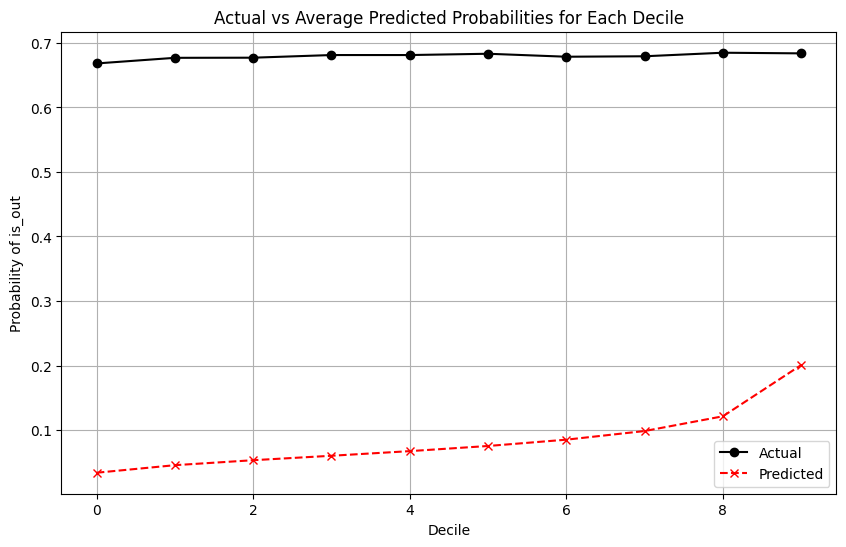

In [115]:
# Calculate probabilities instead of binary predictions
test_df2 = test_df2[pa_inputs+['is_out']].astype(np.float32)
train_df2 = train_df2[pa_inputs+['is_out']].astype(np.float32)

test_features = test_df2[np.asarray(pa_inputs)].values
# Calculate probabilities instead of binary predictions
predicted_probabilities = best_model.predict(test_features)

# Calculate deciles and actual values
df = pd.DataFrame({'Actual': test_df2['is_out'], 'Predicted': predicted_probabilities.flatten()})
df['Decile'] = pd.qcut(df['Predicted'], 10, labels=False)

# Group by decile and calculate mean predicted probability
deciles = df.groupby('Decile').mean()

# Plot actual and predicted values for each decile
plt.figure(figsize=(10, 6))
plt.plot(deciles['Actual'], color='black', marker='o', label='Actual')
plt.plot(deciles['Predicted'], color='red', marker='x', linestyle='dashed', label='Predicted')
plt.xlabel('Decile')
plt.ylabel('Probability of is_out')
plt.title('Actual vs Average Predicted Probabilities for Each Decile')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Load the best model
best_model_path = os.path.join(model_path, binary_filename)
best_model = pickle.load(open(best_model_path, 'rb'))

# Make predictions using the best model
proba = best_model.predict_proba(X_test[pa_inputs])
X_test['is_safe_pred'] = proba[:, 0]  # Assign the first column of probabilities
X_test['is_out_pred'] = proba[:, 1]  # Assign the second column of probabilities

In [ ]:

X_test['decile'] = pd.qcut(X_test['is_out_pred'], 10, labels=False)

globals()["is_out_df"] = X_test.groupby('decile')[['is_out_pred', 'is_out']].mean().reset_index()
globals()["is_out_df"] = X_test.query('year_2022 == True or year_2023 == True').groupby('decile')[['is_out_pred', 'is_out']].mean().reset_index()

# Post Processing:
# Create dataframe to adjust predictions to better fit test data
out_df = X_test.groupby('decile').agg({'is_out_pred': ['max', 'mean'], 'is_out': 'mean'})
out_df.columns = ['is_out_pred_max', 'is_out_pred_mean', 'is_out_mean']

out_df.to_pickle(os.path.join(model_path, 'out_df.pkl'))

In [ ]:
# Create figures
plt.plot(is_out_df['decile'], is_out_df['is_out_pred'], color='red')
plt.plot(is_out_df['decile'], is_out_df['is_out'], color='black')
plt.show() 

In [ ]:
print(binary_filename)
is_out_df['is_out_pred'].iloc[-1] - is_out_df['is_out_pred'].iloc[0], is_out_df['is_out_pred'].iloc[0], is_out_df['is_out_pred'].iloc[-1], best_mse

In [ ]:
print(binary_filename)
is_out_df['is_out_pred'].iloc[-1] - is_out_df['is_out_pred'].iloc[0], is_out_df['is_out_pred'].iloc[0], is_out_df['is_out_pred'].iloc[-1], best_mse

In [ ]:
print(binary_filename)
is_out_df['is_out_pred'].iloc[-1] - is_out_df['is_out_pred'].iloc[0], is_out_df['is_out_pred'].iloc[0], is_out_df['is_out_pred'].iloc[-1], best_mse

In [ ]:
print(binary_filename)
is_out_df['is_out_pred'].iloc[-1] - is_out_df['is_out_pred'].iloc[0], is_out_df['is_out_pred'].iloc[0], is_out_df['is_out_pred'].iloc[-1], best_mse

In [ ]:
# Good ones: 1010 > 1022 > 131

In [ ]:
# model_binary_250250250250250_131.sav
# (0.13008271831001061,
#  0.6048258174486631,
#  0.7349085357586738,
#  2.523358269842466e-05)

# model_binary_250250250250250_1022.sav
# (0.13458647007008917,
#  0.6053316773880753,
#  0.7399181474581644,
#  2.120383168895568e-05)

# model_binary_250250250250250_1010.sav
# (0.1351308602266742,
#  0.6026954195660984,
#  0.7378262797927726,
#  1.2572935527218275e-05)

In [ ]:
dafdafdaf

### Outs

In [ ]:
%%time
# Neural network layers
layers = (250,250,250,250,250)
# To string
layers_str = ''.join(str(x) for x in layers)
# Activation method
activation = 'relu'
# Iterations
iters = 100

outs_filename = f"model_outs_{activation}_{layers_str}_{iters}_{todaysdate}.sav"
print(outs_filename)

# Define the individual models in the ensemble
models = [
    # MLPClassifier(hidden_layer_sizes=(layers), activation=activation, verbose=True, alpha=0.00001, early_stopping=True, validation_fraction=0.1, random_state=3, max_iter=iters),

    MLPClassifier(hidden_layer_sizes=layers, activation='relu', random_state=1, early_stopping=True, learning_rate_init=0.0001, alpha=0.00001, max_iter=iters),
    MLPClassifier(hidden_layer_sizes=layers, activation='relu', random_state=2, early_stopping=True, learning_rate_init=0.0001, alpha=0.00001, max_iter=iters),
    MLPClassifier(hidden_layer_sizes=layers, activation='relu', random_state=3, early_stopping=True, learning_rate_init=0.0001, alpha=0.00001, max_iter=iters),

]

# Create the ensemble classifier using VotingClassifier
model_outs = VotingClassifier(estimators=[('model'+str(i+1), model) for i, model in enumerate(models)], voting='soft', n_jobs=-2).fit(outs_dataset_train[pa_inputs], outs_dataset_train[['eventsModel']].values.ravel())

# Save model
pickle.dump(model_outs, open(os.path.join(model_path, outs_filename), 'wb'))

In [ ]:
# Predict out types
outs_outputs = list(model_outs.classes_)
outs_outputs_pred = [x + "_pred" for x in outs_outputs]

proba = model_outs.predict_proba(outs_dataset_test[pa_inputs])
for i, col in enumerate(outs_outputs_pred):
    outs_dataset_test[f'{col}'] = proba[:, i]

In [ ]:
# Create deciles
for var in outs_outputs:
    outs_dataset_test[f'{var}_act'] = (outs_dataset_test['eventsModel'] == var).astype('int')
    outs_dataset_test[f'{var}_decile'] = pd.qcut(outs_dataset_test[f'{var}_pred'], 10, labels=False)
    df_name = var + "_df"
    # globals()[df_name] = outs_dataset_test.groupby([f'{var}_decile'])[[f'{var}_act', f'{var}_pred']].mean().reset_index()    
    globals()[df_name] = outs_dataset_test.query('year_2022 == True or year_2023 == True').groupby([f'{var}_decile'])[[f'{var}_act', f'{var}_pred']].mean().reset_index()

In [ ]:
# Create figures
fig, axs = plt.subplots(2, 3, figsize=(12, 8))

for i, var in enumerate(outs_outputs):
    row = i // 3  # Calculate the row index based on the iteration
    col = i % 3   # Calculate the column index based on the iteration
    axs[row, col].plot(globals()[f"{var}_df"][f'{var}_decile'], globals()[f"{var}_df"][f'{var}_pred'], color='red')
    axs[row, col].plot(globals()[f"{var}_df"][f'{var}_decile'], globals()[f"{var}_df"][f'{var}_act'], color='black')
    axs[row, col].set_title(var)
    # axs[row, col].set_ylim(0,0.35)


# Add some space between subplots to prevent overlapping
fig.tight_layout(pad=.0)

# Show the figure
plt.show()

### Safe

In [ ]:
%%time
# Neural network layers
layers = (250,250,250,250,250,250,250,250)
# To string
layers_str = ''.join(str(x) for x in layers)
# Activation method
activation = 'relu'
# Iterations
iters = 1000
# Alpha
alpha = 0.0005
# Random state
random_state = 1

safe_filename = f"model_safe_{activation}_{layers_str}_{iters}_{todaysdate}.sav"
print(safe_filename)

# Define the individual models in the ensemble
models = [
    # MLPClassifier(hidden_layer_sizes=layers, activation=activation, verbose=True, alpha=alpha, early_stopping=True, random_state=random_state+2, max_iter=iters),
    # MLPClassifier(hidden_layer_sizes=layers, activation=activation, verbose=True, alpha=alpha, early_stopping=True, random_state=random_state+3, max_iter=iters),
    # MLPClassifier(hidden_layer_sizes=layers, activation=activation, verbose=True, alpha=alpha, early_stopping=True, random_state=random_state+4, max_iter=iters),
    # MLPClassifier(hidden_layer_sizes=layers, activation=activation, verbose=True, alpha=alpha, early_stopping=True, random_state=random_state+5, max_iter=iters),

    
    MLPClassifier(hidden_layer_sizes=layers, activation='relu', random_state=8, early_stopping=True, learning_rate_init=0.0001, alpha=alpha, max_iter=iters),
    MLPClassifier(hidden_layer_sizes=layers, activation='relu', random_state=9, early_stopping=True, learning_rate_init=0.0001, alpha=alpha, max_iter=iters),
    MLPClassifier(hidden_layer_sizes=layers, activation='relu', random_state=10, early_stopping=True, learning_rate_init=0.0001, alpha=alpha, max_iter=iters),
    MLPClassifier(hidden_layer_sizes=layers, activation='relu', random_state=11, early_stopping=True, learning_rate_init=0.0001, alpha=alpha, max_iter=iters),
    MLPClassifier(hidden_layer_sizes=layers, activation='relu', random_state=12, early_stopping=True, learning_rate_init=0.0001, alpha=alpha, max_iter=iters),
]

# Create the ensemble classifier using VotingClassifier
model_safe = VotingClassifier(estimators=[('model'+str(i+1), model) for i, model in enumerate(models)], voting='soft', n_jobs=-2).fit(safe_dataset_train[pa_inputs], safe_dataset_train[['eventsModel']].values.ravel())

# Save model
pickle.dump(model_safe, open(os.path.join(model_path, safe_filename), 'wb'))

In [ ]:
# model_safe = pickle.load(open(os.path.join(model_path, "model_safe_relu_250250250250250250250250_1000_20240313.sav"), 'rb'))

In [ ]:
# Predict safe types
safe_outputs = list(model_safe.classes_)
safe_outputs_pred = [x + "_pred" for x in safe_outputs]

proba = model_safe.predict_proba(safe_dataset_test[pa_inputs])
for i, col in enumerate(safe_outputs_pred):
    safe_dataset_test[f'{col}'] = proba[:, i]

In [ ]:
# Create deciles
for var in safe_outputs:
    safe_dataset_test[f'{var}_act'] = (safe_dataset_test['eventsModel'] == var).astype('int')
    safe_dataset_test[f'{var}_decile'] = pd.qcut(safe_dataset_test[f'{var}_pred'], 10, labels=False)
    df_name = var + "_df"
    # globals()[df_name] = safe_dataset_test.groupby(f'{var}_decile')[[f'{var}_act', f'{var}_pred']].mean().reset_index()
    globals()[df_name] = safe_dataset_test.query('year_2022 == True or year_2023 == True').groupby([f'{var}_decile'])[[f'{var}_act', f'{var}_pred']].mean().reset_index()


In [ ]:
# Create figures
fig, axs = plt.subplots(2, 3, figsize=(12, 8))

for i, var in enumerate(safe_outputs):
    row = i // 3  # Calculate the row index based on the iteration
    col = i % 3   # Calculate the column index based on the iteration
    axs[row, col].plot(globals()[f"{var}_df"][f'{var}_decile'], globals()[f"{var}_df"][f'{var}_act'], color='black')
    axs[row, col].plot(globals()[f"{var}_df"][f'{var}_decile'], globals()[f"{var}_df"][f'{var}_pred'], color='red')
    axs[row, col].set_title(var)
    # axs[row, col].set_ylim(globals()[df_name][f'{var}_act'].min(),globals()[df_name][f'{var}_act'].max())
    

# Add some space between subplots to prevent overlapping
fig.tight_layout(pad=.0)

# Show the figure
plt.show()

In [ ]:
hr_df['hr_mse'] = (hr_df['hr_act'] - hr_df['hr_pred']) ** 2
hr_df['hr_mse'].mean()

In [ ]:
var = 'hr'
safe_dataset_test.groupby(f'{var}_decile')[[f'{var}_pred', f'{var}_act']].mean()

In [ ]:
adfa

In [ ]:
safe_dataset_test.groupby('decile')[['hr_pred', 'hr_act']].mean()

In [ ]:
safe_dataset_test.query('year == "2022" | year == "2023"')[['b1_pred', 'b1_act', 'b2_pred', 'b2_act', 'b3_pred', 'b3_act', 'hr_pred', 'hr_act', 'bb_pred', 'bb_act', 'hbp_pred', 'hbp_act']].mean()

In [ ]:
outs_dataset_test.query('year == "2022" | year == "2023"')[['fo_pred', 'fo_act', 'go_pred', 'go_act', 'lo_pred', 'lo_act', 'po_pred', 'po_act', 'so_pred', 'so_act']].mean()